In [1]:
# importing src directory
import sys
sys.path.append('..')
# experiment imports
import os
import math
import numpy as np
import pandas as pd
import random
from datetime import datetime as dt
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
# project imports
from amm.amm import AMM, SimpleFeeAMM
from amm.fee import TriangleFee, PercentFee, NoFee
# data imports
from gbm.gbm import geometric_brownian_motion
from api_key.my_api_key import api_key

In [2]:

def sim1(n, pair, L0, mu, sig, T, N, dt, spread=0.5):
    """
    simulate AMM market with data calibrated GBM for external oracles and trading agents
    n (int): number of simulations
    pair (str): asset pair for data (e.g. btc-eth)
    L0 (int): number of initial LP tokens
    spread (float): spread for arbitrage agents (e.g. 0.5%)
    return list: list of dataframes for each simulation 
    """

    # # SIM STORAGE # #
    # create list to store dfs from each simulation of amms
    sim_amm_dfs= []
    sim_amms = []
    # parse asset1 and asset2, create USD denominated pairs
    asset1 = pair.split("-")[0] 
    asset2 = pair.split("-")[1]

    # # DATA & GBM CALIBRATION  # # 
    # # FOR WHEN TRYING TO FIND EXPECTED TRADING OUTCOME FOR A SPECIFIC SIMULATION OF MARKET (GBM) # #
    # marketDF = pd.DataFrame({f'{asset1}_gbm_price': geometric_brownian_motion(0.1, 0.15, 16550.764470, 1.0, 1000, 1.0/1000),
    #                             f'{asset2}_gbm_price': geometric_brownian_motion(0.1, 0.15, 1196.325933, 1.0, 1000, 1.0/1000)})
   

   ############################

    mean = 10  # Mean
    sigma = 5# Standard deviation
    a = (0 - mean) / sigma  # Lower bound
    b = (100 - mean) / sigma  # Upper bound

    # Create a frozen distribution object
    trade_sizes = truncnorm(a, b, loc=mean, scale=sigma)
    
    values_list = (trade_sizes.rvs(size=1000)).tolist()

    ############################

    # # TIME SERIES SIMULATIONS # #
    # for each simulation create new set of amms & run new set of trades
    for simulation in range(n):
        
        # # DATA & GBM CALIBRATION  # #
        marketDF = pd.DataFrame({f'{asset1}_gbm_price': geometric_brownian_motion(mu=mu, sigma=sig, S0=16550.764470, T=T, N=N, dt=dt),
                                f'{asset2}_gbm_price': geometric_brownian_motion(mu=mu, sigma=sig, S0=1196.325933, T=T, N=N, dt=dt)})
        

        ############################

        # # PLOTTING # #
        plt.plot(marketDF[f'{asset1}_gbm_price'], label=f'{asset1} Price')
        # plt.plot(marketDF[f'{asset2}_gbm_price'], label=f'{asset2} Price')
        plt.legend()
        plt.show()

        ############################
        
        
        
        new_cols = [f'{asset1}_inv', f'{asset2}_inv', 'L_inv',  # asset inventory
                    f'F{asset1}_inv', f'F{asset2}_inv', 'FL_inv',  # fee inventory
                    f'{asset1}_price_dt', f'{asset2}_price_dt', # change price over time
                    f'{asset1}_inv_dt', f'{asset2}_inv_dt', # change inventory over time
                    f'amm_{asset1}/{asset2}', f'gbm_{asset1}/{asset2}'] # amm ratios
        marketDF = marketDF.assign(**{col: None for col in new_cols})       
        # initial market ratios
        marketDF[f'gbm_{asset1}/{asset2}'] = marketDF[f'{asset1}_gbm_price'] / marketDF[f'{asset2}_gbm_price']  
        
        # # INITIAL PORTFOLIO # #
        A0 = math.sqrt(L0**2 * marketDF[f'{asset1}_gbm_price'][0]/marketDF[f'{asset2}_gbm_price'][0]) # evenly distribute assets according to market prices
        B0 = L0**2 / A0
        market_portfolio = {asset1: A0, asset2: B0, "L":L0} # initial portfolio         
        marketDF.loc[0, f'{asset1}_inv'] = A0 # set initial asset1 inventory
        marketDF.loc[0, f'{asset2}_inv'] = B0 # set initial asset2 inventory
        marketDF.loc[0, 'L_inv']= L0
        marketDF.loc[0, f'amm_{asset1}/{asset2}'] = A0/B0
        marketDF.loc[0, f'F{asset1}_inv'] = 0. # set initial fee inventory
        marketDF.loc[0, f'F{asset2}_inv'] = 0. # set initial fee inventory
        marketDF.loc[0, 'FL_inv']= 0.
        marketDF.loc[0, f'{asset1}_price_dt'] = 0. # set initial price change
        marketDF.loc[0, f'{asset2}_price_dt'] = 0. # set initial price change
        marketDF.loc[0, f'{asset1}_inv_dt'] = 0. # set initial inventory change
        marketDF.loc[0, f'{asset2}_inv_dt'] = 0. # set initial inventory change
        
        # # AMM INITIALIZATION # #
        nofeeAMM = SimpleFeeAMM(fee_structure = NoFee(), init_portfolio=market_portfolio)
        percentAMM = SimpleFeeAMM(fee_structure = PercentFee(0.01), init_portfolio=market_portfolio)
        triAMM = SimpleFeeAMM(fee_structure = TriangleFee(0.003, 0.0001, -1), init_portfolio=market_portfolio) 
        percentDF = marketDF.copy(deep=True)
        nofeeDF = marketDF.copy(deep=True)
        triDF = marketDF.copy(deep=True)
        amms = [(nofeeAMM, nofeeDF), (percentAMM, percentDF), (triAMM, triDF)] # store pairs of amm type & df for updating

        # # ARBITRAGE AGENT # #
        for amm, df in amms: # update market data with amm data
            # # SIMULATION (0 to t) # #
            for t in range(1, N): # iterate over each timestep in crypto market data
    # ADDED NEW AGENT LOGIC   
    # -> i changed so traders trade today (t) based on yesterday (t-1) and the amm is updated at the end of the day
                print("-"*50)
                print(df[f'amm_{asset1}/{asset2}'][t-1])
                print(df[f'gbm_{asset1}/{asset2}'][t-1])
                print("-"*50)
                
                if amm == percentAMM:
                    if df[f'amm_{asset1}/{asset2}'][t-1] > (df[f'gbm_{asset1}/{asset2}'][t-1] * 1.003): # rule-based arbitrage agents in the market
                        asset_out, asset_in, asset_in_n = "B", "A", values_list[t] # modeling market efficiency
                    elif (df[f'amm_{asset1}/{asset2}'][t-1] * 1.003) < df[f'gbm_{asset1}/{asset2}'][t-1]:
                        asset_out, asset_in, asset_in_n = asset1, asset2, values_list[t] * df[f'gbm_{asset1}/{asset2}'][t-1]
                    else: asset_out, asset_in, asset_in_n = asset1, asset2, 0.0
                elif amm == triAMM:
                    trade_size = values_list[t]
                    if df[f'amm_{asset1}/{asset2}'][t-1] > (df[f'gbm_{asset1}/{asset2}'][t-1]):
                        asset_out, asset_in, asset_in_n = asset2, asset1, trade_size
                    elif (df[f'amm_{asset1}/{asset2}'][t-1]) < df[f'gbm_{asset1}/{asset2}'][t-1]:
                        asset_out, asset_in, asset_in_n = asset1, asset2, values_list[t] * df[f'gbm_{asset1}/{asset2}'][t-1]
                    else: asset_out, asset_in, asset_in_n = asset1, asset2, 0.0
                    ass_out, info = amm._quote_no_fee(asset_out, asset_in, trade_size)
                    curr_ratio = new_row[f'{asset1}_inv'] / new_row[f'{asset2}_inv']
                    new_ratio = (new_row[f'{asset1}_inv'] + info["asset_delta"][f"{asset1}"]) / (new_row[f'{asset2}_inv'] + info["asset_delta"][f"{asset2}"])
                    difference = 1 - (new_ratio / curr_ratio)
                    if abs(difference) > .003: baseline = 1.00155
                    else: baseline = 1.003
                    if df[f'amm_{asset1}/{asset2}'][t-1] > (df[f'gbm_{asset1}/{asset2}'][t-1] * baseline): # rule-based arbitrage agents in the market
                        asset_out, asset_in, asset_in_n = asset2, asset1, trade_size # modeling market efficiency
                    elif (df[f'amm_{asset1}/{asset2}'][t-1] * baseline) < df[f'gbm_{asset1}/{asset2}'][t-1]:
                        asset_out, asset_in, asset_in_n = asset1, asset2, values_list[t] * df[f'gbm_{asset1}/{asset2}'][t-1]
                    else: asset_out, asset_in, asset_in_n = asset1, asset2, 0.0
                else:
                    if df[f'amm_{asset1}/{asset2}'][t-1] > (df[f'gbm_{asset1}/{asset2}'][t-1]):
                        asset_out, asset_in, asset_in_n = asset2, asset1, values_list[t]
                    elif (df[f'amm_{asset1}/{asset2}'][t-1]) < df[f'gbm_{asset1}/{asset2}'][t-1]:
                        asset_out, asset_in, asset_in_n = asset1, asset2, values_list[t] * df[f'gbm_{asset1}/{asset2}'][t-1]
                    else: asset_out, asset_in, asset_in_n = asset1, asset2, 0.0
                # # TRADE # #
                succ, info = amm.trade_swap(asset_out, asset_in, asset_in_n) # call trade for each AMM
                # # UPDATE DATA # #
                new_row = {f'{asset1}_gbm_price':df.loc[t, f'{asset1}_gbm_price'], 
                           f'{asset2}_gbm_price':df.loc[t, f'{asset2}_gbm_price'],
                            # add inventory to df
                            f'{asset1}_inv': amm.portfolio[asset1], 
                            f'{asset2}_inv': amm.portfolio[asset2], 
                            'L_inv': amm.portfolio['L'],
                            # add fee change to df
                            f'F{asset1}_inv': amm.fees[f'F{asset1}'], 
                            f'F{asset2}_inv': amm.fees[f'F{asset2}'], 
                            'FL_inv': amm.fees['FL'],
                            # add price change to df
                            f'{asset1}_price_dt':np.log(df[f'{asset1}_gbm_price'][t]/df[f'{asset1}_gbm_price'][t-1]), 
                            f'{asset2}_price_dt':np.log(df[f'{asset2}_gbm_price'][t]/df[f'{asset2}_gbm_price'][t-1]), 
                            # add inventory change to df
                            f'{asset1}_inv_dt': info['asset_delta'][asset1], 
                            f'{asset2}_inv_dt': info['asset_delta'][asset2],
                            # add ratios
                            f'amm_{asset1}/{asset2}':amm.portfolio[asset1]/amm.portfolio[asset2], 
                            f'gbm_{asset1}/{asset2}':df[f'{asset1}_gbm_price'][t]/df[f'{asset2}_gbm_price'][t]} # amm ratios
                # append new row to df                                         # TRYING TO FIX BUG !!!!
                df.iloc[t] = new_row     
        # after sim and updates
        for amm, df in amms:
            sim_amm_dfs.append(df)
            sim_amms.append(amm)
    return sim_amm_dfs, sim_amms # return list of dfs for each simulation

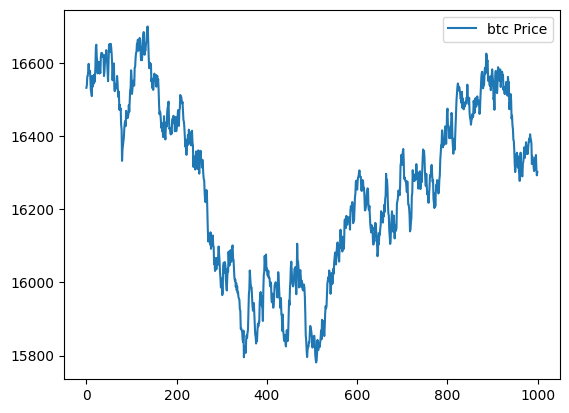

--------------------------------------------------
13.83716311256426
13.837163112564262
--------------------------------------------------
--------------------------------------------------
5.3208640376996765
13.82846386711425
--------------------------------------------------
--------------------------------------------------
3.591554033908064
13.883990338140649
--------------------------------------------------
--------------------------------------------------
2.885625713640592
13.888008802954298
--------------------------------------------------
--------------------------------------------------
2.687896864060436
13.908432754516642
--------------------------------------------------
--------------------------------------------------
2.1589468983702824
13.895530808916261
--------------------------------------------------
--------------------------------------------------
1.4684685972507872
13.854158504836823
--------------------------------------------------
-------------------------

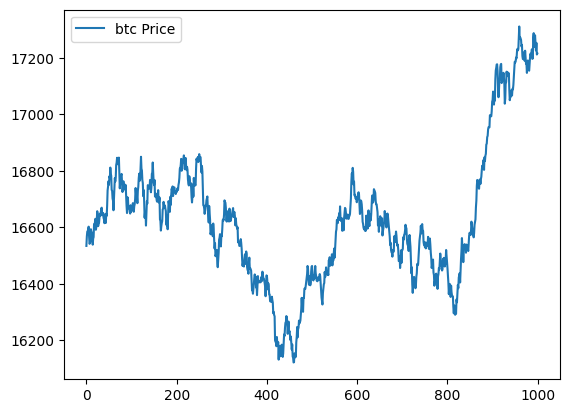

--------------------------------------------------
13.813243188210945
13.813243188210945
--------------------------------------------------
--------------------------------------------------
13.813243188210945
13.866693335392453
--------------------------------------------------
--------------------------------------------------
7.569508274093999
13.870721383439301
--------------------------------------------------
--------------------------------------------------
5.551342495948902
13.87526109085916
--------------------------------------------------
--------------------------------------------------
5.034609940696564
13.911622804375844
--------------------------------------------------
--------------------------------------------------
3.7511229431001762
13.940120772646345
--------------------------------------------------
--------------------------------------------------
2.2858311649233483
13.911268708962375
--------------------------------------------------
------------------------

In [3]:
simm_amm_dfs, simm_amms = sim1(n=2, pair="btc-eth", L0=1000, mu=0.1, sig=0.15, T=1.0, N=1000, dt=1.0/10000, spread=0.5) # run simulation

In [4]:
# # NOTES FROM LAST MEETING:
# FOCUS MORE ON TESTING FEES THROUGH SIM

# # EXPERIMENTS TODO: # #
# [1] run for large simulations and evaluate over time - explore different time periods to test from (different market conditions and lengths of historical windows) and different frequencies (1h, 1d, 1w)
# [2] identify GBM paths that deplete pools (depletion of liquidity) and have both fall in value (impermanent loss) to show how fee accumulation compares ot general trend (law of large #s)
        # impermanent loss evaluation could allow for an expected value calculation for LP returns (expected value of fees vs. impermanent loss)
# [3] use stock data to see how compares
# [4] make sure to highlight how different fee AMMs (basically fees) are affected by different market conditions and therefore how fee accumulation is affected

# # UPDATES # #
# [1] *importing stock data to use instead of crypto (more in line with goal application and can properly use GBM to simulate)
# [2] considering train/test split for calibrating GBM and simulating trades source data (not overly urgent given not forecasting)
# [3] maybe also considering changing source data from vwap if stick with crypto data
        # multiple price streams for multiple external oracles